In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from atom3d.datasets import load_dataset
import collections as col
from collapse import atom_info
from collapse.utils import deserialize, deserialize
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import normalize

In [9]:
data = deserialize('../COLLAPSE/data/datasets/pdb100_embeddings/pdb_embeddings.pkl')
# data = deserialize('../COLLAPSE/data/datasets/scop40_embeddings/scop40_embeddings.pkl')

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components='mle', random_state=77)
pca.fit(data['embeddings'])

PCA(n_components='mle', random_state=77)

In [30]:
pca.explained_variance_ratio_[:50].sum()

0.8991332923045592

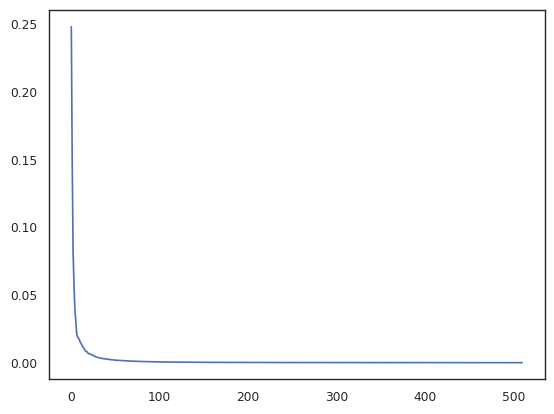

In [22]:
plt.plot(range(pca.n_components_), pca.explained_variance_ratio_)

In [6]:
res_df = pd.read_csv('./data/pdb100_cluster_tuning.csv')
melted = res_df.melt('k', ['Within-cluster sum of squares', 'SCOP entropy', 'Folds per cluster', 'Samples per cluster'])

In [7]:
res_df

,k,Within-cluster sum of squares,SCOP entropy,Families per cluster,Superfamilies per cluster,Folds per cluster,Samples per cluster
0,20,190646.484375,3.836854,3573.100000,1488.100000,952.350000,751548.850000
1,100,146811.171875,3.737421,2874.200000,1217.230000,799.530000,150309.770000
2,1000,108250.812500,3.457287,1108.136000,545.540000,389.506000,15030.977000
3,5000,87910.320312,3.087562,395.806400,235.337800,182.486800,3006.195400
4,10000,80443.671875,2.881502,235.115300,151.827600,122.114500,1503.097700
5,20000,73403.882812,2.652070,134.602750,93.936200,78.341250,751.548850
6,50000,65204.292969,2.320560,61.135840,46.537520,40.630880,300.619540
7,100000,88574.382812,2.396723,30.631163,23.341007,20.662515,153.454043


<Figure size 300x700 with 0 Axes>

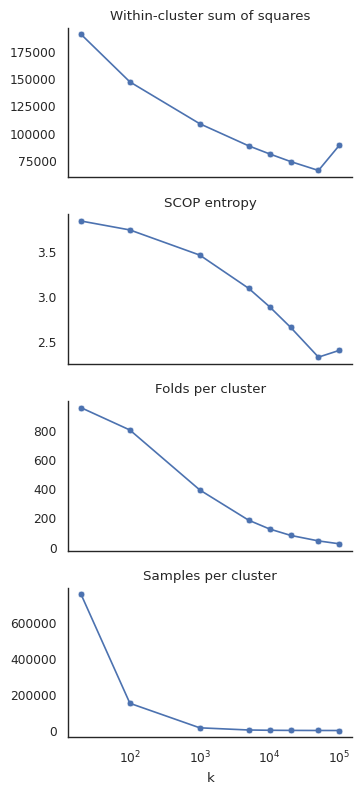

In [31]:
sns.set(context='paper', style='white')
plt.figure(figsize=(3,7))
g = sns.FacetGrid(melted, row='variable', sharex=True, sharey=False, height=2, aspect=2.0, palette='tab20')
g.map(sns.scatterplot, 'k', 'value')
g.map(sns.lineplot, 'k', 'value')
g.set_titles('{row_name}')
g.set(ylabel='')
plt.xscale('log')
plt.xlabel('k')
plt.savefig('./data/pdb100_cluster_tuning.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

In [2]:
columns = ['pdb', 'chain', 'resolution', 'ligand', 'lig_chain', 'ligand_resids', 'catalytic_resids', 'ec_number', 'GO_terms', 'ligand_resnum', 'length']
data = []
pdbres_to_ligands = col.defaultdict(dict)
pdbres_to_catres = col.defaultdict(dict)
with open('../BioLiP/BioLiP.txt') as f:
    for line in f:
        pdb, chain, resolution, _, ligand, lig_chain, _, sites_pdbnum, sites_renum, catalytic_pdbnum, catalytic_renum, ec_number, go_terms, _, _, _, _, _, _, ligand_resnum, seq = line.strip().split('\t')
        data.append([pdb, chain, resolution, ligand, lig_chain, sites_pdbnum.split(), catalytic_pdbnum.split(), ec_number, go_terms, ligand_resnum, len(seq)])
        for res in sites_pdbnum.split():
            if res not in pdbres_to_ligands[pdb + chain]:
                pdbres_to_ligands[pdb + chain][res] = []
            pdbres_to_ligands[pdb + chain][res].append(ligand)
        for res in catalytic_pdbnum.split():
            if res not in pdbres_to_catres[pdb + chain]:
                pdbres_to_catres[pdb + chain][res] = []
            pdbres_to_catres[pdb + chain][res].append(ligand)
biolip = pd.DataFrame(data, columns=columns)

In [109]:
biolip

,pdb,chain,resolution,ligand,lig_chain,ligand_resids,catalytic_resids,ec_number,GO_terms,ligand_resnum,length
0,101m,A,2.07,HEM,A,"[F43, R45, V68, S92, H93, H97, I99, Y103]",[],,"0005344,0015671,0019825,0020037,0046872,0071588",155,154
1,102m,A,1.84,HEM,A,"[F43, R45, T67, L89, S92, H93, H97, I99, Y103]",[],,"0005344,0015671,0019825,0020037,0046872,0071588",155,154
2,103m,A,2.07,HEM,A,"[F43, R45, S92, H93, H97, I99, Y103]",[],,"0005344,0015671,0019825,0020037,0046872,0071588",155,154
3,104m,A,1.71,HEM,A,"[F43, R45, V68, S92, H93, H97, I99, Y103, F138]",[],,"0005344,0015671,0019825,0020037,0046872,0071588",155,153
4,105m,A,2.02,HEM,A,"[F43, R45, H64, V68, L89, H93, H97, I99]",[],,"0005344,0015671,0019825,0020037,0046872,0071588",155,153
...,...,...,...,...,...,...,...,...,...,...,...
820318,9xim,C,2.4,MN,C,"[E181, E217, D245, D292]","[H54, D57, M88, E181, K183, E217, H220, D245, ...",5.3.1.5,"0000287,0005737,0005975,0009045,0016853,004273...",395,391
820319,9xim,C,2.4,MN,C,"[E217, H220, D255, D257]","[H54, D57, M88, E181, K183, E217, H220, D245, ...",5.3.1.5,"0000287,0005737,0005975,0009045,0016853,004273...",396,391
820320,9xim,D,2.4,XLS,D,"[H54, W137, E181, K183, H220, D292]","[H54, D57, M88, E181, K183, E217, H220, D245, ...",5.3.1.5,"0000287,0005737,0005975,0009045,0016853,004273...",397,392
820321,9xim,D,2.4,MN,D,"[E181, E217, D245, D292]","[H54, D57, M88, E181, K183, E217, H220, D245, ...",5.3.1.5,"0000287,0005737,0005975,0009045,0016853,004273...",395,392


In [110]:
len(pdbres_to_ligands), len(pdbres_to_catres)

(424206, 85332)

In [43]:
pdbres_to_ligands['101mA']

{'F43': ['HEM'],
 'R45': ['HEM'],
 'V68': ['HEM'],
 'S92': ['HEM'],
 'H93': ['HEM'],
 'H97': ['HEM'],
 'I99': ['HEM'],
 'Y103': ['HEM']}

In [11]:
dataset  = load_dataset('/scratch/users/aderry/pdb_clusters_50000/tmp_1', 'lmdb')
len(dataset)

5722

In [41]:
dataset.ids()[:5]

['200l', '101m', '201l', '102l', '102m']

In [3]:
scop_names = {}
pdb_to_scop = col.defaultdict(dict)
with open('../mappings/dir.des.scope.2.08-stable.txt') as f:
    for line in f:
        if line[0] == '#':
            continue
        else:
            l = line.strip().split('\t')
            _, cat, cls, pdbcd, desc = l
            if cat in ['cl', 'cf', 'sf', 'fa']:
                scop_names[cls] = f'{cls} ({desc})'
            elif cat == 'px':
                pdbc = pdbcd[1:6]
                loc_range = desc.split()[-1].split(':')[-1]
                if len(loc_range) == 0:
                    pdb_to_scop[pdbc]['all'] = cls
                else:
                    loc_split = loc_range.split('-')
                    try:
                        if len(loc_split) == 2:
                            start, end = [int(x) for x in loc_split]
                        elif len(loc_split) == 3:
                            start, end = int(''.join(loc_split[:2])), int(loc_split[-1])
                        elif len(loc_split) == 4:
                            start, end = int(''.join(loc_split[:2])), int(''.join(loc_split[2:]))
                    except ValueError:
                        continue
                    for i in range(start, end+1):
                        pdb_to_scop[pdbc][str(i)] = cls
print(len(scop_names), 'total scop nodes')
print(len(pdb_to_scop), 'chains with scop annotations')

9296 total scop nodes
252822 chains with scop annotations


In [4]:
def get_scop(pdbc, resid):
    pdbc = pdbc.lower()
    scop_dict = pdb_to_scop[pdbc]
    if 'all' in scop_dict:
        return scop_dict['all']
    resnum = resid[1:]
    return scop_dict.get(resnum, 'N/A')

In [5]:
cluster_aa = {c: {a:0 for a in atom_info.aa_abbr} for c in range(50000)}
cluster_resids = {c: col.defaultdict(list) for c in range(50000)}
cluster_ligands = col.defaultdict(list)
cluster_bfactors = col.defaultdict(list)
cluster_catres = col.defaultdict(list)
cluster_scop = col.defaultdict(list)
for n in range(1,31):
    dataset  = load_dataset(f'/scratch/users/aderry/pdb_clusters_50000/tmp_{n}', 'lmdb')
    for item in tqdm(dataset, desc=f'{n} of 30'):
        pdbid = item['id']
        clusters = item['clusters']
        chains = item['chains']
        resids = item['resids']
        bfactors = item['confidence']
        aas = [r[0] for r in resids]
        for i, c in enumerate(clusters):
            pdbc = pdbid + chains[i]
            cluster_aa[c][aas[i]] += 1
            cluster_resids[c][pdbc].append(resids[i])
            cluster_bfactors[c].append(bfactors[i])
            cluster_scop[c].append(get_scop(pdbc, resids[i]))
            
            ligs = pdbres_to_ligands[pdbc]
            if resids[i] in ligs:
                cluster_ligands[c].extend(ligs[resids[i]])
                
            ligs = pdbres_to_catres[pdbc]
            if resids[i] in ligs:
                cluster_catres[c].extend(ligs[resids[i]])

30 of 30: 100%|██████████| 5722/5722 [24:23<00:00,  3.91it/s]  


In [7]:
from collapse.utils import serialize, deserialize
serialize({'center_aa': cluster_aa, 'pdb_resids': cluster_resids, 'ligands': cluster_ligands, 'catalytic_residues': cluster_catres, 'bfactors': cluster_bfactors, 'SCOP': cluster_scop}, './data/cluster_50000_info.pkl')

In [2]:
cluster_info = deserialize('./data/cluster_50000_info.pkl')

In [3]:
cluster_stats = deserialize(f'./data/cluster_stats_50000.pkl')

In [7]:
cluster_stats[2].keys()

dict_keys(['center_aa', 'scop'])

In [3]:
import itertools
from scipy.stats import entropy

total_envs = 0
aa_pairs = list(itertools.combinations(atom_info.aa_abbr[:20], 2))
cluster_sizes = {}
aa_entropy = []
aa_submat = pd.DataFrame(np.zeros((20,20)), index=atom_info.aa_abbr[:20], columns=atom_info.aa_abbr[:20])
aa_distributions = []
for clust, aa_freqs in tqdm(cluster_info['center_aa'].items()):
    cts = np.array(list(aa_freqs.values()))
    total = cts.sum()
    cluster_sizes[clust] = total
    if total == 0:
        continue
    ent = entropy(cts / total)
    aa_entropy.append(ent)
    aa_distributions.append(cts / total)
    total_envs += total
    # for a1, a2 in aa_pairs:
    #     val = (aa_freqs[a1] + aa_freqs[a2]) / total
    #     aa_submat.loc[a1,a2] += val
    #     aa_submat.loc[a2,a1] += val
print(total_envs, 'total environments')

100%|██████████| 50000/50000 [00:01<00:00, 41822.46it/s]

104863360 total environments


In [15]:
total_envs

104863360

In [6]:
sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)[:10], sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)[-10:]

([(2504, 187002),
  (4138, 160392),
  (1987, 147860),
  (4068, 96556),
  (22020, 93036),
  (5431, 81634),
  (40046, 19654),
  (23138, 17504),
  (21656, 14114),
  (2350, 14110)],
 [(38162, 0),
  (40980, 0),
  (43153, 0),
  (45022, 0),
  (45582, 0),
  (46000, 0),
  (46741, 0),
  (46872, 0),
  (47200, 0),
  (48910, 0)])

In [14]:
(np.array(list(cluster_sizes.values())) < 4000).mean()

0.90872

In [57]:
clusterer = deserialize(f'data/pdb100_cluster_fit_{k}.pkl')
list(zip(np.array(data['pdbs'])[np.where(clusterer.labels_ == 2504)[0]], np.array(data['resids'])[np.where(clusterer.labels_ == 2504)[0]]))

[('1bwo_A', 'G30'),
 ('1hsl_A', 'A213'),
 ('1jqi_A', 'A25'),
 ('1r42_A', 'A528'),
 ('1xmi_A', 'S589'),
 ('1yis_A', 'A44'),
 ('2fel_A', 'A39'),
 ('2fr1_A', 'A1493'),
 ('2hzl_A', 'A312'),
 ('2qdi_A', 'S88'),
 ('3b7a_A', 'S88'),
 ('3b87_A', 'S88'),
 ('3d0g_A', 'A528'),
 ('3i6v_A', 'A244'),
 ('3it4_B', 'C272'),
 ('3ivl_A', 'A378'),
 ('3lfu_A', 'A180'),
 ('3qkx_A', 'A15'),
 ('3tql_A', 'A248'),
 ('4a1f_A', 'C271'),
 ('4f7f_A', 'A85'),
 ('4neg_A', 'A34'),
 ('4p7y_A', 'A392'),
 ('4pow_A', 'A257'),
 ('4u8u_C', 'A97'),
 ('4zv2_A', 'A213'),
 ('5amb_A', 'A514'),
 ('5dic_A', 'A111'),
 ('5hc8_A', 'A206'),
 ('5hxq_A', 'A210'),
 ('5kin_B', 'A34'),
 ('5l9w_A', 'A210'),
 ('6ayh_A', 'A21'),
 ('6egr_A', 'A392'),
 ('6eu9_A', 'A324'),
 ('6ft2_A', 'A213'),
 ('6l6n_A', 'A349'),
 ('6mku_E', 'A213'),
 ('6ml0_A', 'A213'),
 ('6ml9_E', 'A213'),
 ('6mla_E', 'A213'),
 ('6mld_A', 'A213'),
 ('6mli_E', 'A213'),
 ('6mlj_A', 'A213'),
 ('6mln_E', 'A213'),
 ('6mlp_E', 'A213'),
 ('6r2n_A', 'A392'),
 ('6te6_A', 'A81'),
 ('7d

In [65]:
aa_distributions = np.array(aa_distributions)[:,:20]
aa_corr = pd.DataFrame(np.corrcoef(aa_distributions.T), index=atom_info.aa_abbr[:20], columns=atom_info.aa_abbr[:20])
aa_corr.shape

(20, 20)

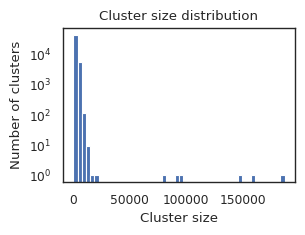

In [94]:
sns.set(context='paper', style='white')
plt.figure(figsize=(3,2))
plt.hist(cluster_sizes, bins=50)
plt.xlabel('Cluster size')
plt.ylabel('Number of clusters')
plt.title('Cluster size distribution')
plt.yscale('log')
plt.savefig('./figures/cluster_size_dist.svg', dpi=300, bbox_inches='tight', format='svg')

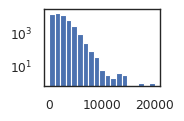

In [36]:
sns.set(context='paper', style='white')
plt.figure(figsize=(1.5,1))
plt.hist(cluster_sizes, bins=np.linspace(0,20000,20))
plt.yscale('log')
plt.savefig('./figures/cluster_size_dist_inset.svg', dpi=300, bbox_inches='tight', format='svg')

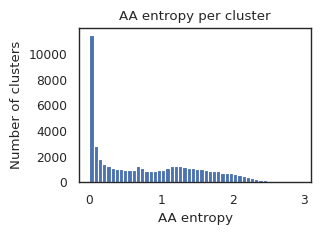

In [66]:
sns.set(context='paper', style='white')
plt.figure(figsize=(3,2))
plt.hist(aa_entropy, bins=50)
plt.xlabel('AA entropy')
plt.ylabel('Number of clusters')
plt.title('AA entropy per cluster')
plt.savefig('./figures/cluster_aa_entropy.svg', dpi=300, bbox_inches='tight', format='svg')

In [47]:
p = np.ones(20)*0.05
print(entropy(p))

2.9957322735539904


In [46]:
p = np.array([0.5, 0.5] + [0]*18)
print(entropy(p))

0.6931471805599453


In [19]:
(np.array(aa_entropy) == 0).sum(), (np.array(aa_entropy) < 0.7).sum()

(4345, 25522)

<Figure size 640x480 with 0 Axes>

<Figure size 500x500 with 0 Axes>

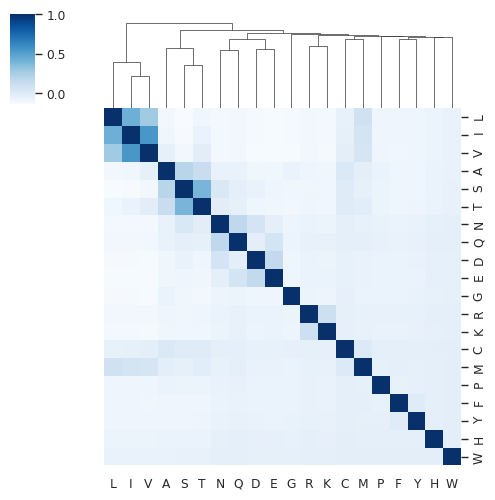

In [92]:
plt.clf()
g = sns.clustermap(aa_corr, cmap='Blues', figsize=(5,5))
g.ax_row_dendrogram.set_visible(False)
plt.yticks(None)
plt.savefig('./figures/cluster_aa_cooccurence.svg', dpi=300, bbox_inches='tight', format='svg')

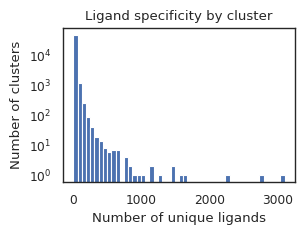

In [58]:
num_ligands = [len(np.unique(v)) for v in cluster_info['ligands'].values()] + [0] * (50000-len(cluster_info['ligands']))

sns.set(context='paper', style='white')
plt.figure(figsize=(3,2))
plt.hist(num_ligands, bins=50)
plt.xlabel('Number of unique ligands')
plt.ylabel('Number of clusters')
plt.title('Ligand specificity by cluster')
plt.yscale('log')
plt.savefig('./figures/cluster_num_unique_ligands.svg', dpi=300, bbox_inches='tight', format='svg')

In [34]:
sorted({k:len(np.unique(v)) for k,v in cluster_info['ligands'].items()}.items(), key=lambda x: x[1], reverse=True)[8000:8020]

[(49406, 20),
 (46974, 20),
 (29756, 20),
 (44327, 20),
 (26636, 20),
 (1414, 20),
 (3311, 20),
 (22823, 20),
 (13088, 20),
 (19471, 20),
 (9544, 20),
 (48095, 20),
 (27515, 20),
 (32228, 20),
 (15528, 20),
 (35500, 20),
 (5683, 20),
 (16745, 20),
 (28580, 20),
 (23105, 20)]

In [35]:
col.Counter(cluster_info['ligands'][5683])

Counter({'NA': 137,
         'K': 14,
         'ARG': 2,
         '7A8': 2,
         '2BN': 2,
         'FPP': 1,
         'SNE': 1,
         'ADP': 1,
         'LEU': 1,
         'HJM': 1,
         'B2': 1,
         'AG2': 1,
         'MPG': 1,
         'BP2': 1,
         'ALA': 1,
         'LA6': 1,
         'V0A': 1,
         'ILE': 1,
         'PFF': 1,
         'VAL': 1})

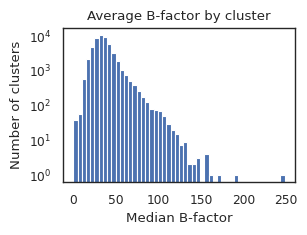

In [5]:
mean_bfactors = [np.median(v) for v in cluster_info['bfactors'].values()]

sns.set(context='paper', style='white')
plt.figure(figsize=(3,2))
plt.hist(mean_bfactors, bins=50)
plt.xlabel('Median B-factor')
plt.ylabel('Number of clusters')
plt.title('Average B-factor by cluster')
plt.yscale('log')
plt.savefig('./figures/cluster_bfactors.svg', dpi=300, bbox_inches='tight', format='svg')

Text(14.166287500000005, 0.5, 'Count')

<Figure size 300x200 with 0 Axes>

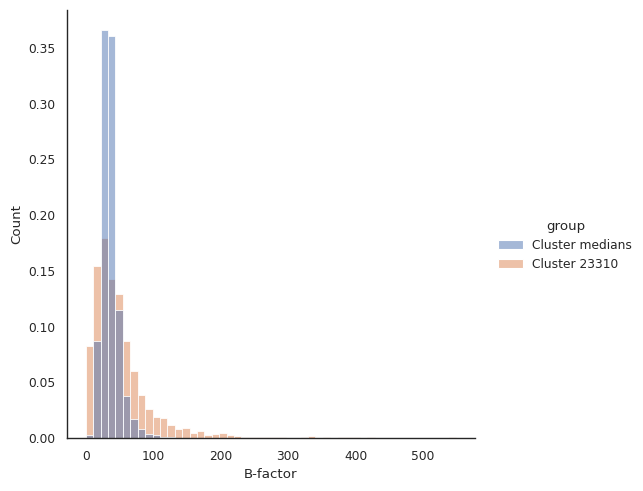

In [17]:
clust = 23310

mean_bfactors = [np.median(v) for v in cluster_info['bfactors'].values()]
df = pd.DataFrame({'bfactor': mean_bfactors + cluster_info['bfactors'][clust], 'group': ['Cluster medians']*len(mean_bfactors) + [f'Cluster {clust}']*len(cluster_info['bfactors'][clust])})

sns.set(context='paper', style='white')
plt.figure(figsize=(3,2))
sns.displot(data=df, x='bfactor', hue='group', bins=50, stat='probability', common_norm=False)
plt.xlabel('B-factor')
plt.ylabel('Count')
# plt.yscale('log')